<h1 style="color: green">Beijing Air Quality Data (2010-15)</h1>
<h1 style="font-size:32px;">MISSING IMPUTATION</h1>

<hr>

## Table of Contents
* [1. Load Raw Data](#loadraw)
    * [2.1 Data Transformations](#loadraw_1)
* [2. Model Development](#modeldev)
    * [2.1 Ramdom Forest](#modeldev_rf)
    * [2.2 Lasso-Lars Regression](#modeldev_reg)
    * [2.3 Gradient Boosting Regression](#modeldev_gb)
* [3. Impute Missing Values](#impute)
    * [3.1 Verify Qualitative Behavior of Modeled Dependent Variable](#impute_ver)
* [4. Expand Dataset & Redevelop Model](#remodeldev)
    * [4.1 Random Forest](#remodeldev_1)
    * [4.2 Gradient Boosting Regression](#remodeldev_2)

<hr>

Use Pandas, Numpy, and sklearn to impute missing Particulate Matter values

In [295]:
# Load Modules
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import datetime
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.linear_model import LassoLars

## 1. Load Raw Data<a class="anchor" id="loadraw"></a>

In [296]:
beijing = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv")
beijing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
No       43824 non-null int64
year     43824 non-null int64
month    43824 non-null int64
day      43824 non-null int64
hour     43824 non-null int64
pm2.5    41757 non-null float64
DEWP     43824 non-null int64
TEMP     43824 non-null float64
PRES     43824 non-null float64
cbwd     43824 non-null object
Iws      43824 non-null float64
Is       43824 non-null int64
Ir       43824 non-null int64
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [297]:
#Dependent Variable
target = 'pm2.5'

In [298]:
is_target_missing = beijing[target].isnull()

In [299]:
print('Total Cases Missing Target Variable: {}'.format(sum(is_target_missing)))

Total Cases Missing Target Variable: 2067


### 1.1 Data Transformations<a class="anchor" id="loadraw_1"></a>
#### Drop Unwanted

In [300]:
dropvars = ['No']

#### Convert Categorical to Numeric Using Dummies

In [301]:
beijing2 = pd.get_dummies(beijing,columns=['year','month','day','hour','cbwd'], drop_first=True)

In [302]:
beijing2.drop(dropvars,axis=1,inplace=True)

#### Put Into Numpy Array Format

In [303]:
X_pred = beijing2.loc[is_target_missing].drop(target,axis=1).values
X_true = beijing2.loc[~is_target_missing].drop(target,axis=1).values

In [304]:
y = beijing2.loc[~is_target_missing,target].values.astype('int32')

#### Scale Predictors to Improve Estimation Efficiency

In [305]:
scaler = RobustScaler()
X_true = scaler.fit_transform(X_true)
X_pred = scaler.transform(X_pred)
print("X_true Shape: {}".format(X_true.shape))
print("X_pred Shape: {}".format(X_pred.shape))

X_true Shape: (41757, 77)
X_pred Shape: (2067, 77)


## 2. Model Development<a class="anchor" id="modeldev"></a>
Build Diverse Models and Select Best Fit
#### Prepare Cross-Validation Folds

In [306]:
cv = KFold(n_splits=5, shuffle=True, random_state=2019)

### 2.1 Random Forest<a class="anchor" id="modeldev_rf"></a>

In [307]:
rf = RandomForestRegressor(n_estimators=200,max_depth=15,min_samples_leaf=30,random_state=19)

In [308]:
t0 = datetime.now()

oof = np.zeros(y.shape[0])
for train, test in cv.split(X_true,y):
    rf.fit(X_true[train], y[train])
    oof[test] = rf.predict(X_true[test])

print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - t0))

Time elapsed (hh:mm:ss.ms) 0:00:52.771879


In [309]:
print("msle {:.5f}".format(mean_squared_log_error(y,oof))+
      " R-square {:.4f}".format(r2_score(y,oof)))

msle 0.43315 R-square 0.5687


### 2.2 Lasso - Lars Regression<a class="anchor" id="modeldev_reg"></a>
Uses Log Transformation of Dependent Variable

In [310]:
reg = LassoLars(alpha=0.007,normalize=False,max_iter=100)
# Data already normalized
# Model often unstable for low alpha

In [311]:
t0 = datetime.now()

oof = np.zeros(y.shape[0])
for train, test in cv.split(X_true,y):
    reg.fit(X_true[train], np.log1p(y[train]))
    oof[test] = np.expm1(reg.predict(X_true[test]))

print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - t0))

Time elapsed (hh:mm:ss.ms) 0:00:00.231054


In [312]:
print("msle {:.5f}".format(mean_squared_log_error(y,oof))+
      " R-square {:.4f}".format(r2_score(y,oof)))

msle 0.54739 R-square 0.2160


### 2.3 Gradient Boosting Regression<a class="anchor" id="modeldev_gb"></a>
BEST FIT (R-square 0.8383)

In [313]:
gb = GradientBoostingRegressor(n_estimators = 300, max_depth = 15, max_features = 50, subsample = 0.7) # Rsq:0.8383

In [314]:
t0 = datetime.now()

oof = np.zeros(y.shape[0])
for train, test in cv.split(X_true,y):
    gb.fit(X_true[train], y[train])
    oof[test] = np.maximum(gb.predict(X_true[test]),0)
    #gb.fit(X_true[train], np.log1p(y[train]))
    #oof[test] = np.expm1(gb.predict(X_true[test]))

print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - t0))

Time elapsed (hh:mm:ss.ms) 0:28:23.583863


In [315]:
print(#"msle {:.5f}".format(mean_squared_log_error(y,oof))+
      " R-square {:.4f}".format(r2_score(y,oof)))

 R-square 0.8366


## 3. Impute Missing Values<a class="anchor" id="modeldev"></a>
Use best fit (Gradient Boosting Regressor)

In [316]:
new_y = np.zeros(beijing.shape[0])
new_y[~is_target_missing] = y
new_y[is_target_missing] = gb.predict(X_pred)

#### Store Results

In [317]:
beijing['model_pm2.5'] = new_y
beijing.to_csv("beijing.csv", index=False)

### 3.1 Verify Qualitative Behavior of Modeled Dependent Variable<a class="anchor" id="impute_ver"></a>

#### Modeled PM Distribution by Month

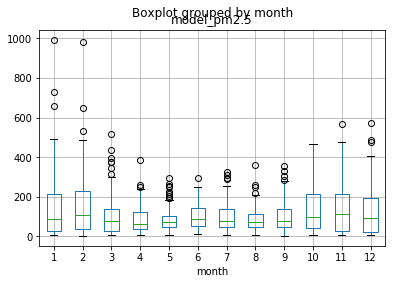

In [318]:
ax = beijing.loc[beijing.hour==1].boxplot("model_pm2.5",by="month")

#### Modeled PM Distribution by Month and Wind Direction

In [319]:
grouped = beijing.groupby(["month","cbwd"])["model_pm2.5"].median().unstack()
grouped.style.format("{:.1f}").highlight_max(axis=1,color="royalblue").\
set_caption("Max Median by Month and Wind Direction")

cbwd,NE,NW,SE,cv
month,,,,
1,42.0,30.4,119.5,129.0
2,36.0,41.0,103.0,133.5
3,42.0,23.0,92.8,118.0
4,53.0,24.0,91.0,84.0
5,66.5,38.0,82.0,80.0
6,58.0,39.0,97.0,88.0
7,59.0,35.0,92.0,83.5
8,67.0,36.0,79.0,82.0
9,53.0,33.6,85.0,83.0


In [ ]:
del beijing

## Expand Dataset & Redevelop Model<a class="anchor" id="remodeldev"></a>
Will this model improve if Lagged Variables are Included? By how much?

In [320]:
beijing2 = pd.concat([beijing2,
                      beijing2.drop(target, axis=1).shift().rename(lambda x: x+'_lag1',    axis=1),
                      beijing2.drop(target, axis=1).shift(24).rename(lambda x: x+'_lag24', axis=1)
                     ], axis=1)
beijing2.shape

(43824, 232)

In [321]:
beijing2 = beijing2.iloc[24:,:]

In [322]:
is_target_missing = beijing2[target].isnull()

In [323]:
X_pred = beijing2.loc[is_target_missing].drop(target,axis=1).values
X_true = beijing2.loc[~is_target_missing].drop(target,axis=1).values

In [324]:
y = beijing2.loc[~is_target_missing,target].values.astype('int32')

In [325]:
scaler = RobustScaler()
X_true = scaler.fit_transform(X_true)
X_pred = scaler.transform(X_pred)

### Random Forest Model<a class="anchor" id="remodeldev_1"></a>

In [327]:
rf = RandomForestRegressor(n_estimators=200,max_depth=15,min_samples_leaf=30,random_state=19,max_features=50)

In [328]:
t0 = datetime.now()

oof = np.zeros(y.shape[0])
for train, test in cv.split(X_true,y):
    rf.fit(X_true[train], y[train])
    oof[test] = rf.predict(X_true[test])
    #rf.fit(X_true[train], np.log1p(y[train]))
    #oof[test] = np.expm1(rf.predict(X_true[test]))

print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - t0))

Time elapsed (hh:mm:ss.ms) 0:00:48.683880


In [329]:
print("msle {:.5f}".format(mean_squared_log_error(y,oof))+
      " R-square {:.4f}".format(r2_score(y,oof)))

msle 0.44614 R-square 0.5752


Not by a lot!

### Gradient Boosting Model<a class="anchor" id="remodeldev_2"></a>
BEST FIT (R-square 0.8176)

In [330]:
#gb = GradientBoostingRegressor(n_estimators = 100, max_depth = 10) ### Best Parameters No Log: R-square 0.8176
gb = GradientBoostingRegressor(n_estimators = 300, max_depth = 15, max_features = 50, subsample = 0.7)

In [331]:
t0 = datetime.now()

oof = np.zeros(y.shape[0])
for train, test in cv.split(X_true,y):
    #gb.fit(X_true[train], y[train])
    #oof[test] = np.maximum(gb.predict(X_true[test]),0)
    gb.fit(X_true[train], np.log1p(y[train]))
    oof[test] = np.expm1(gb.predict(X_true[test]))

print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - t0))

Time elapsed (hh:mm:ss.ms) 0:40:43.759735


In [332]:
pd.DataFrame({'var':list(beijing2.drop(target,axis=1).columns),'fi':gb.feature_importances_}).\
sort_values(by=['fi'], ascending=False).head(15)

,var,fi
80,Iws_lag1,0.048200
157,Iws_lag24,0.048199
3,Iws,0.045184
154,DEWP_lag24,0.042955
77,DEWP_lag1,0.042948
0,DEWP,0.042926
156,PRES_lag24,0.042229
155,TEMP_lag24,0.040704
1,TEMP,0.037202
78,TEMP_lag1,0.036939


In [333]:
print(#"msle {:.5f}".format(mean_squared_log_error(y,oof))+
      " R-square {:.4f}".format(r2_score(y,oof)))

 R-square 0.8119


<p> Not at all!
<p> Dataset Expansion is Not Worth the Effort.